## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from geopy.distance import great_circle
from geographiclib.geodesic import Geodesic

## Reading Data

In [112]:
train = pd.read_csv("split/train.csv")
val = pd.read_csv("split/val.csv")

## Data Exploration

In [3]:
train.info()
print('======================================================')
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229319 entries, 0 to 229318
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0

In [4]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,1.534793,1.665353,-73.973475,40.750947,-73.973421,40.751829,9.548850e+02
std,0.498788,1.315723,0.065404,0.033745,0.065432,0.035782,3.882070e+03
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,34.359695,1.000000e+00
25%,1.000000,1.000000,-73.991852,40.737372,-73.991341,40.735928,3.970000e+02
50%,2.000000,1.000000,-73.981728,40.754131,-73.979767,40.754551,6.620000e+02
75%,2.000000,2.000000,-73.967346,40.768379,-73.963036,40.769833,1.074000e+03
max,2.000000,7.000000,-61.335529,51.881084,-61.335529,43.921028,2.227612e+06


In [5]:
train.duplicated().sum()

0

In [6]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


## EDA

### . trip duration (Target)

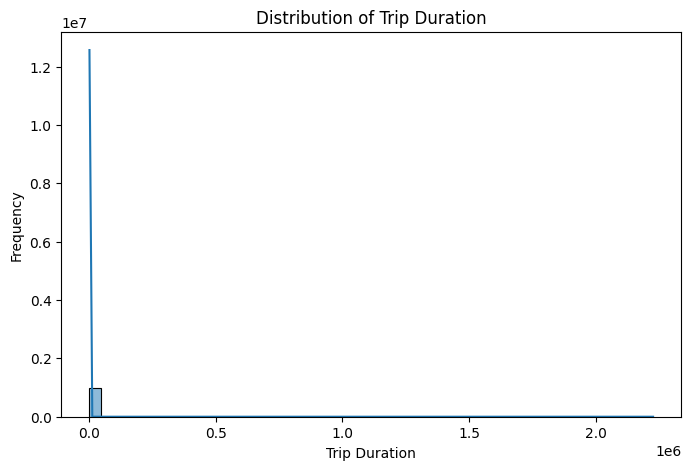

In [7]:
plt.figure(figsize = (8,5))
sns.histplot(train['trip_duration'],bins=50 ,kde =True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration')
plt.ylabel ('Frequency')
plt.show()

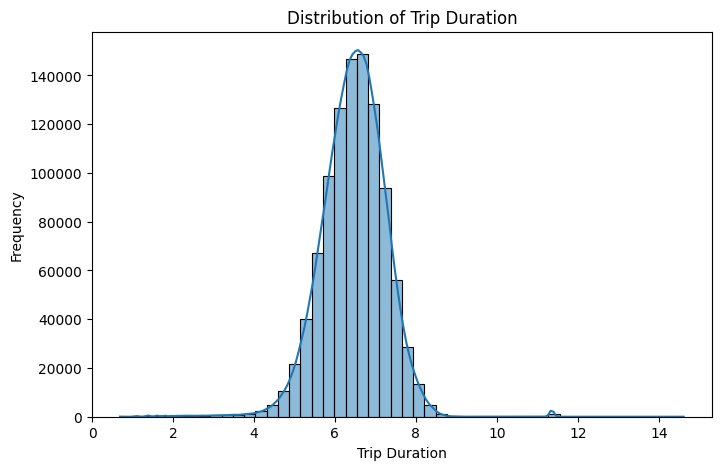

In [8]:
plt.figure(figsize = (8,5))
sns.histplot(np.log1p (train['trip_duration']),bins=50 ,kde =True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration')
plt.ylabel ('Frequency')
plt.show()

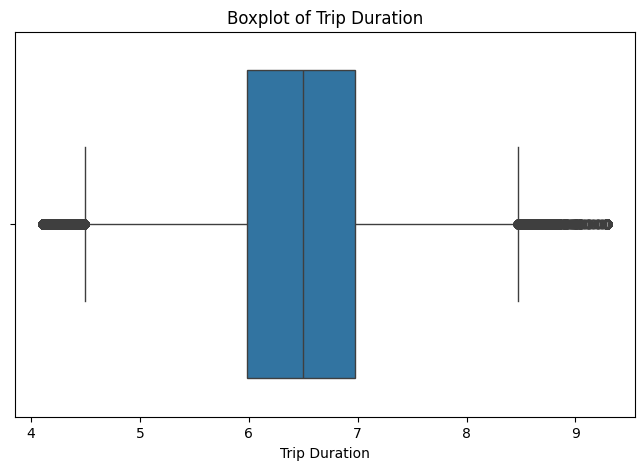

In [110]:
plt.figure(figsize=(8,5))
sns.boxplot(x=np.log1p (train['trip_duration_clipped']))
plt.title('Boxplot of Trip Duration')
plt.xlabel('Trip Duration')
plt.show()

In [114]:
#handle outliers using clipping
lower_bound=train['trip_duration'].quantile(0.01)
upper_bound =train ['trip_duration'].quantile(0.99)
train['trip_duration_clipped']= train ['trip_duration'].clip(lower =lower_bound ,upper = upper_bound )

# apply the log transformation
train ['log_trip_duration'] = np.log1p(train['trip_duration_clipped'])

In [103]:
train['trip_duration_clipped'].max()

15000

In [94]:
upper_bound, lower_bound

(3434.0100000000093, 245.0)

In [88]:
train['trip_duration'>=3600].count()

TypeError: '>=' not supported between instances of 'str' and 'int'

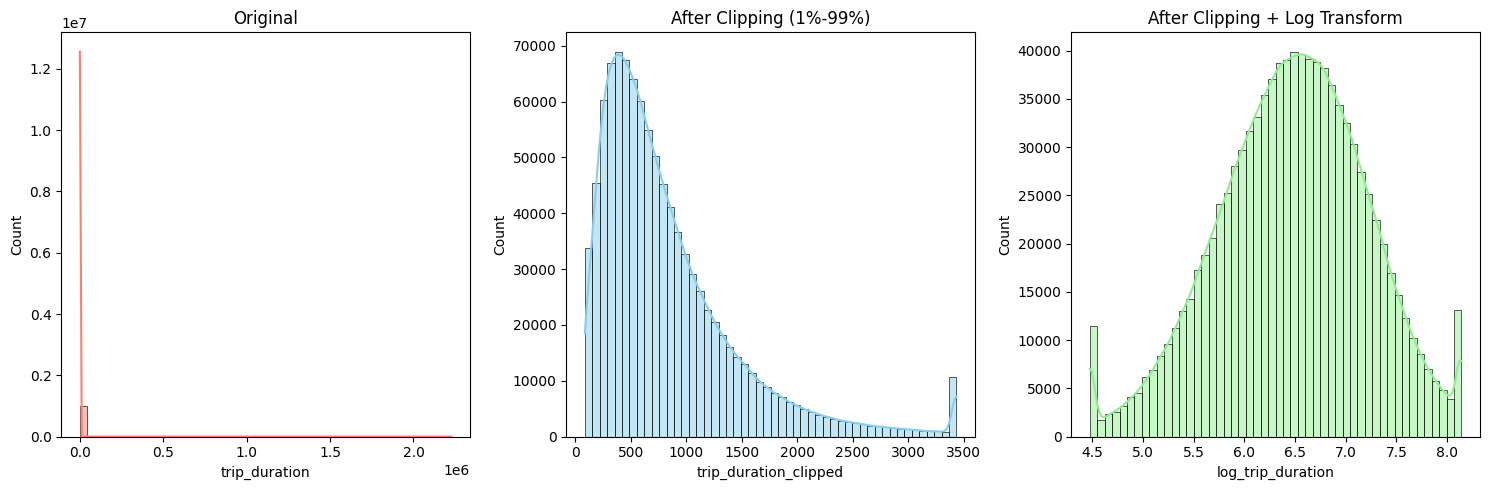

In [115]:
plt.figure(figsize=(15,5))

plt.subplot (1,3,1)
sns.histplot(train['trip_duration'], bins=50, kde=True, color='salmon')
plt.title('Original')

plt.subplot (1,3,2)
sns.histplot(train['trip_duration_clipped'], bins=50, kde=True, color='skyblue')
plt.title('After Clipping (1%-99%)')


plt.subplot(1,3,3)
sns.histplot(train['log_trip_duration'], bins=50, kde=True, color='lightgreen')
plt.title('After Clipping + Log Transform')

plt.tight_layout()
plt.show()

In [116]:
print("Skewness before:", train['trip_duration'].skew())
print("Skewness before:", train['trip_duration_clipped'].skew())
print("Skewness after :", train['log_trip_duration'].skew())

Skewness before: 202.55575426164614
Skewness before: 1.737797911760756
Skewness after : -0.20374162449589545


### . ID

In [12]:
train.drop(columns='id', axis=1, inplace=True)

### . Vendor ID

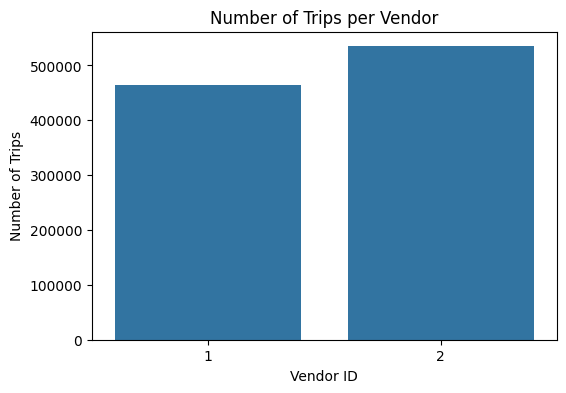

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x=train['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Vendor')
plt.show()

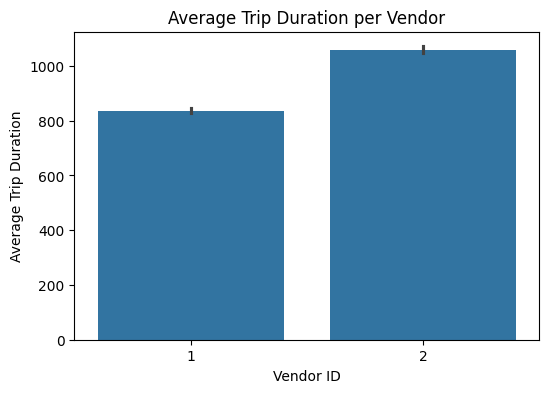

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(x=train['vendor_id'], y=train['trip_duration'])
plt.xlabel('Vendor ID')
plt.ylabel('Average Trip Duration')
plt.title('Average Trip Duration per Vendor')
plt.show()

### . pickup datetime

In [15]:
# convert pickup_datetime to datetime
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

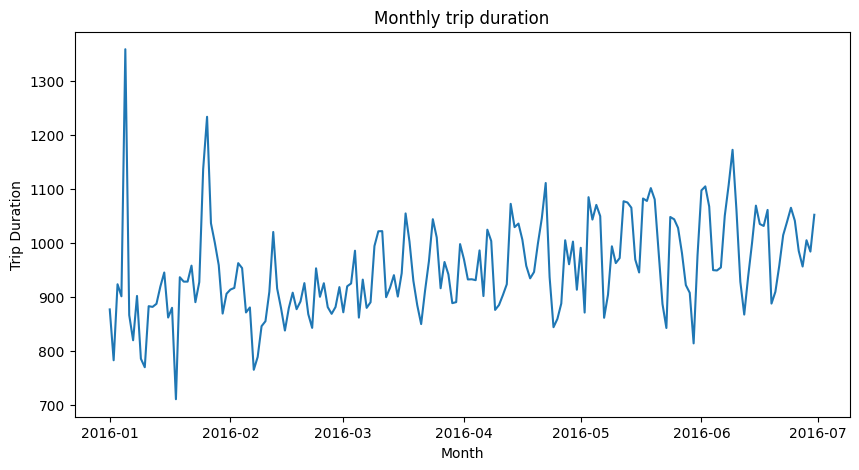

In [16]:
group = train.groupby(train['pickup_datetime'].dt.date)['trip_duration'].mean()

plt.figure(figsize=(10,5))
plt.plot(group.index, group.values)
plt.xlabel('Month')
plt.ylabel('Trip Duration')
plt.title('Monthly trip duration')
plt.show()

In [17]:
train['pickup_datetime'].dt.year.unique()

array([2016])

In [18]:
train['day'] = train['pickup_datetime'].dt.day
train['month'] = train['pickup_datetime'].dt.month
train['day_of_week'] = train['pickup_datetime'].dt.weekday
train['hour'] = train['pickup_datetime'].dt.hour

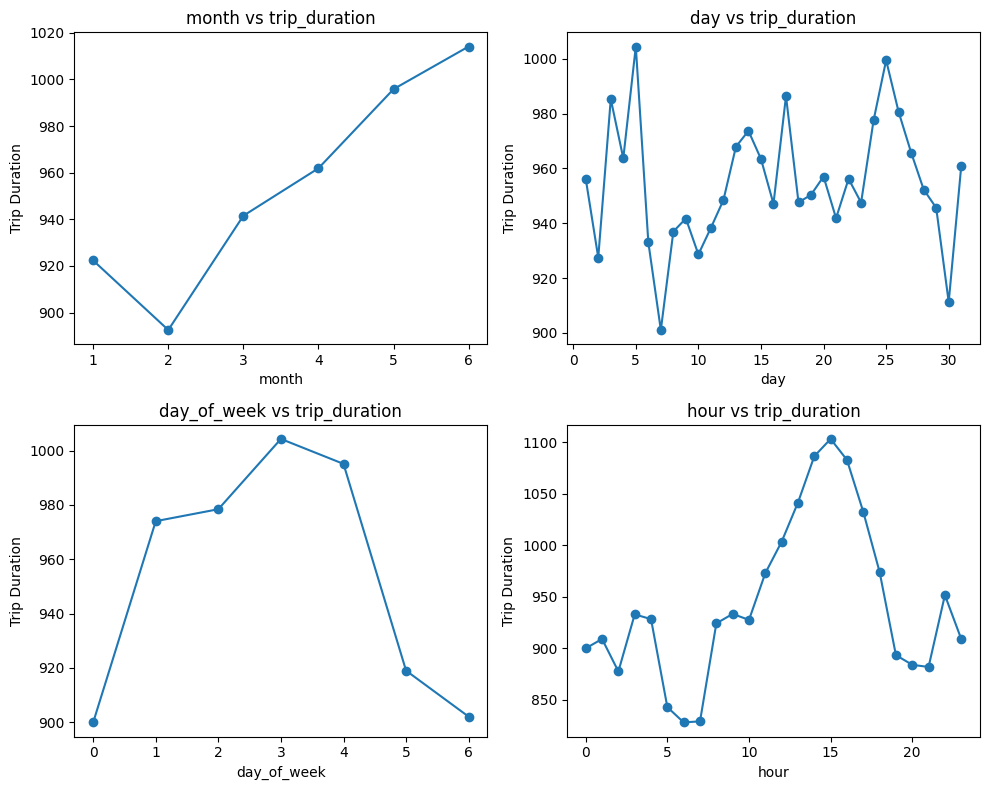

In [19]:
features = ['month', 'day', 'day_of_week', 'hour']
plt.figure(figsize=(10, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2,2,i)
    group = train.groupby(feature)['trip_duration'].mean()
    plt.plot(group.index, group.values, marker='o')
    plt.xlabel(feature)
    plt.ylabel('Trip Duration')
    plt.title(f'{feature} vs trip_duration')
 

plt.tight_layout()
plt.show()

In [20]:
working = [0, 1 , 2 , 3, 4]
rush = [10,11,12,13,14,15, 16, 17]

train['Working_days'] = train['pickup_datetime'].dt.weekday.isin(working).astype(int)
is_working_day = train['pickup_datetime'].dt.weekday.isin(working)
is_rush_time = train['pickup_datetime'].dt.hour.isin(rush)
train['rush_hour'] = (is_working_day & is_rush_time).astype(int)

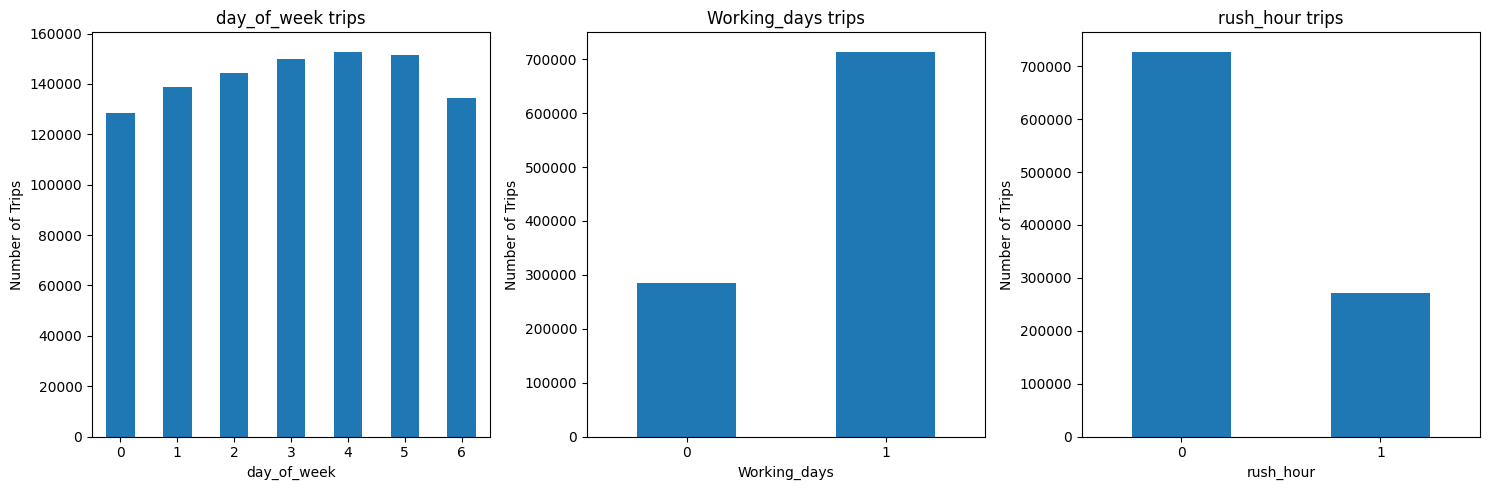

In [21]:
features = ['day_of_week', 'Working_days', 'rush_hour']
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    group = train.groupby(feature)['trip_duration'].count()
    group.plot(kind='bar', ax=plt.gca())
    plt.xlabel(feature)
    plt.ylabel('Number of Trips')
    plt.title(f'{feature} trips')
    plt.xticks(rotation=0)
 

plt.tight_layout()
plt.show()

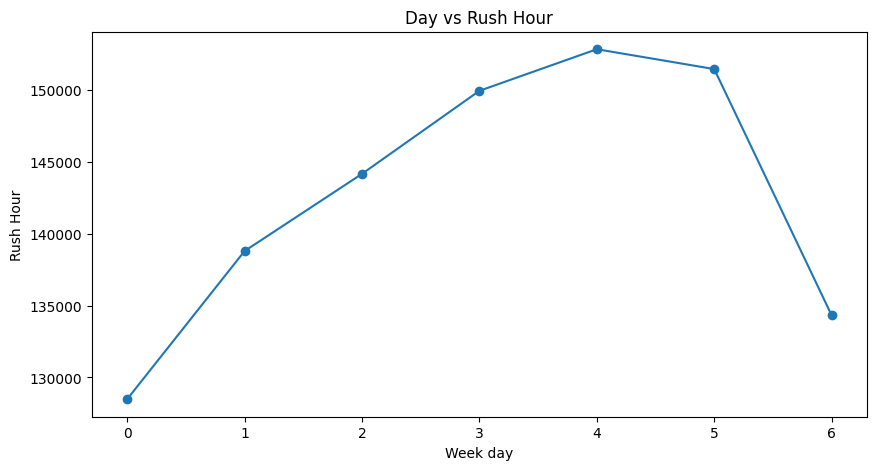

In [22]:
group = train.groupby(train['day_of_week'])['rush_hour'].count()

plt.figure(figsize=(10,5))
plt.plot(group.index, group.values, marker='o')
plt.xlabel('Week day')
plt.ylabel('Rush Hour')
plt.title('Day vs Rush Hour')
plt.show()

### . passenger_count

In [23]:
train['passenger_count'].unique()

array([1, 5, 2, 4, 3, 6, 0, 7], dtype=int64)

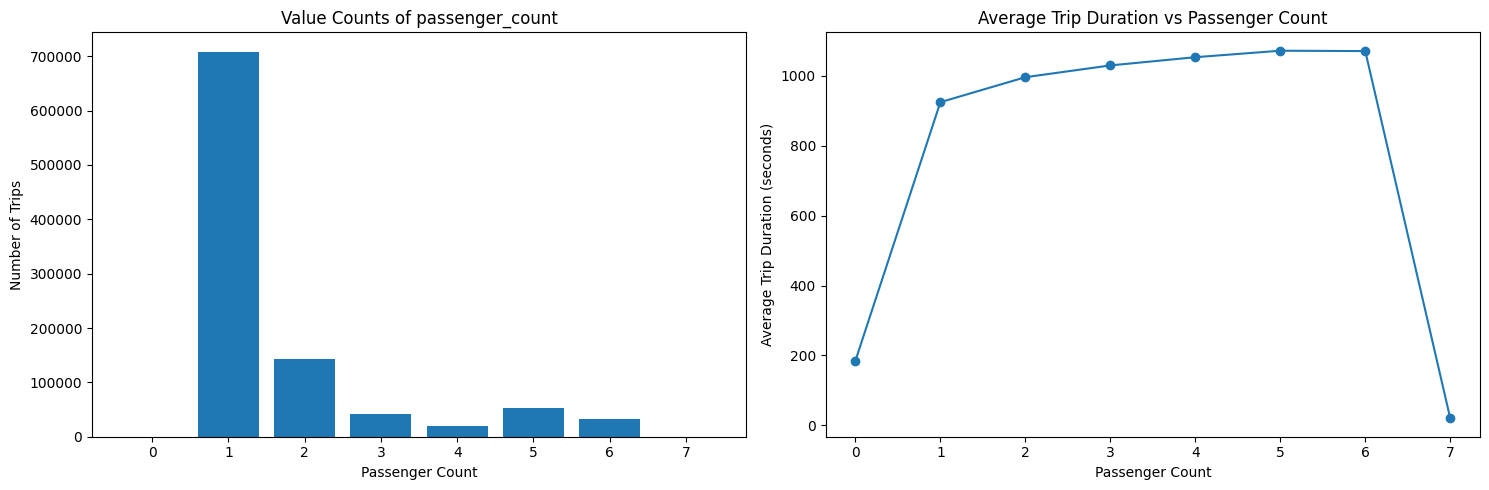

In [24]:
group = train.groupby('passenger_count')['trip_duration'].mean()
plt.figure(figsize=(15, 5)) 


plt.subplot(1, 2, 1)
plt.bar(x=train['passenger_count'].value_counts().index, height=train['passenger_count'].value_counts())
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.title('Value Counts of passenger_count')

plt.subplot(1, 2, 2)
plt.plot(group.index, group.values, marker='o')
plt.xlabel('Passenger Count')
plt.ylabel('Average Trip Duration (seconds)')
plt.title('Average Trip Duration vs Passenger Count')
plt.xticks(group.index)

plt.tight_layout()
plt.show()

In [25]:
train['passenger_count'].value_counts()

passenger_count
1    708628
2    143907
5     53635
3     41012
6     33287
4     19491
0        38
7         2
Name: count, dtype: int64

In [26]:
train = train[~train['passenger_count'].isin([0, 7])]

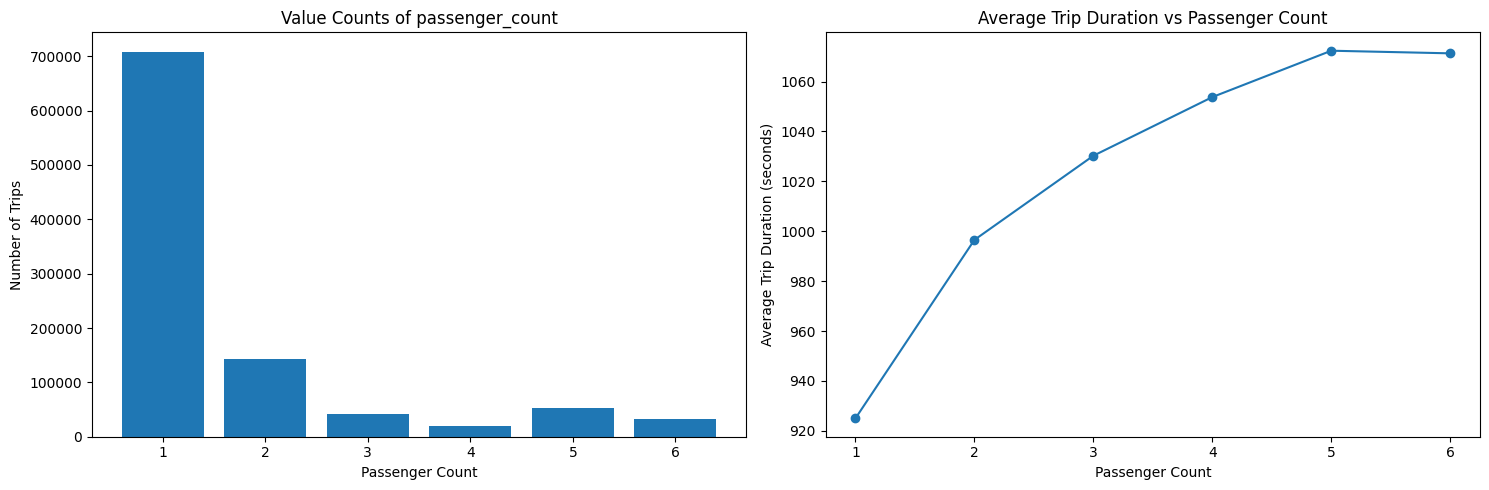

In [27]:
group = train.groupby('passenger_count')['trip_duration'].mean()
plt.figure(figsize=(15, 5)) 


plt.subplot(1, 2, 1)
plt.bar(x=train['passenger_count'].value_counts().index, height=train['passenger_count'].value_counts())
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.title('Value Counts of passenger_count')

plt.subplot(1, 2, 2)
plt.plot(group.index, group.values, marker='o')
plt.xlabel('Passenger Count')
plt.ylabel('Average Trip Duration (seconds)')
plt.title('Average Trip Duration vs Passenger Count')
plt.xticks(group.index)

plt.tight_layout()
plt.show()

### . latitude and longtitude

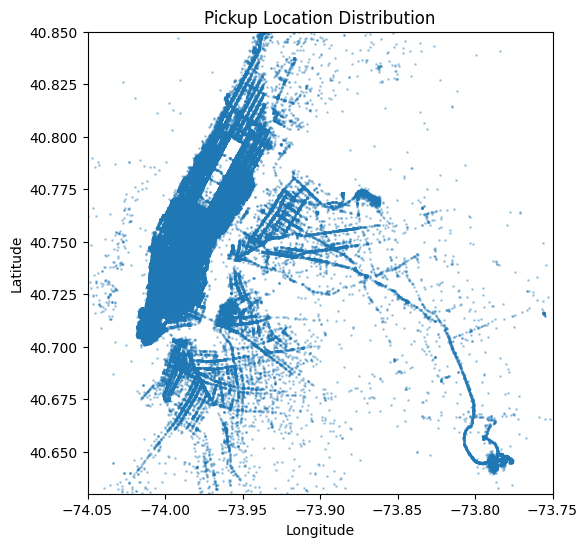

In [28]:
plt.figure(figsize=(10,8))
plt.scatter(
    train['pickup_longitude'], 
    train['pickup_latitude'], 
    s=1, alpha=0.3
)
plt.title('Pickup Location Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

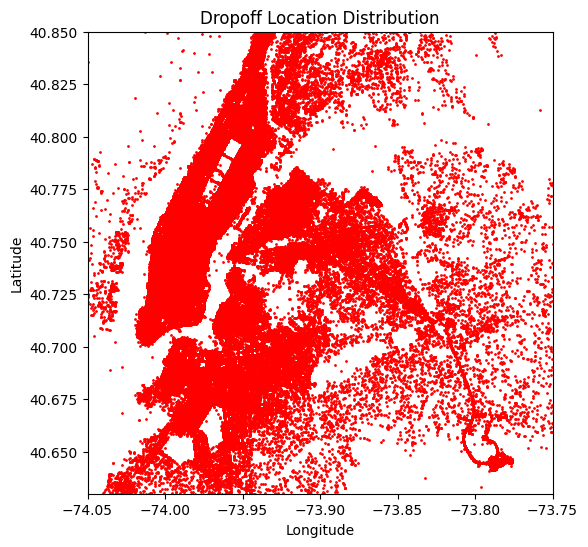

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(
    train['dropoff_longitude'], 
    train['dropoff_latitude'], 
    s=1, alpha=1, color='red'
)
plt.title('Dropoff Location Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

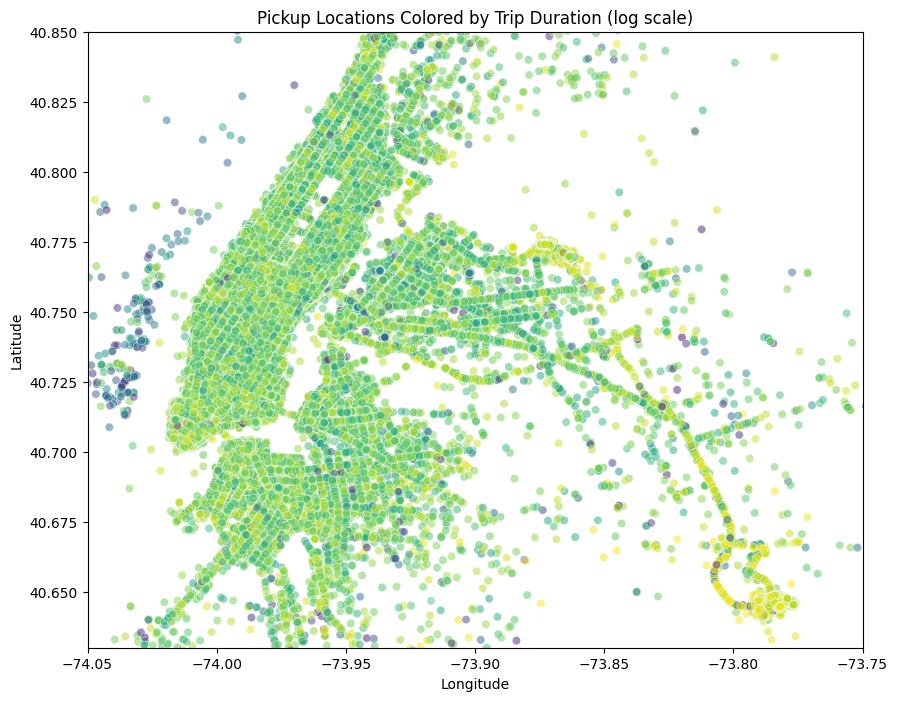

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train[train['trip_duration'] < 3600],  # remove extreme outliers
    x='pickup_longitude',
    y='pickup_latitude',
    hue=np.log1p(train[train['trip_duration'] < 3600]['trip_duration']),
    palette='viridis',
    alpha=0.5,
    legend=False
)
plt.title('Pickup Locations Colored by Trip Duration (log scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

In [31]:
train['manhattan_distance'] = np.abs(train['pickup_longitude'] - train['dropoff_longitude']) + np.abs(train['pickup_latitude'] - train['dropoff_latitude'])

In [32]:
train['haversine_distance'] = train.apply(
    lambda row: great_circle(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).km, axis=1)

Distance Ratio

In [33]:
train['distance_ratio'] = train['manhattan_distance'] / (train['haversine_distance']+ 0.0000000000000000001) 

In [34]:
train['midpoint_latitude'] = (train['pickup_latitude'] + train['dropoff_latitude']) / 2
train['midpoint_longitude'] = (train['pickup_longitude'] + train['dropoff_longitude']) / 2

In [35]:
GEO_WGS84 = Geodesic.WGS84

def get_geodesic_bearing(row):
    g = GEO_WGS84.Inverse(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude'])
    return g['azi1'] % 360

train['bearing'] = train.apply(get_geodesic_bearing, axis=1)

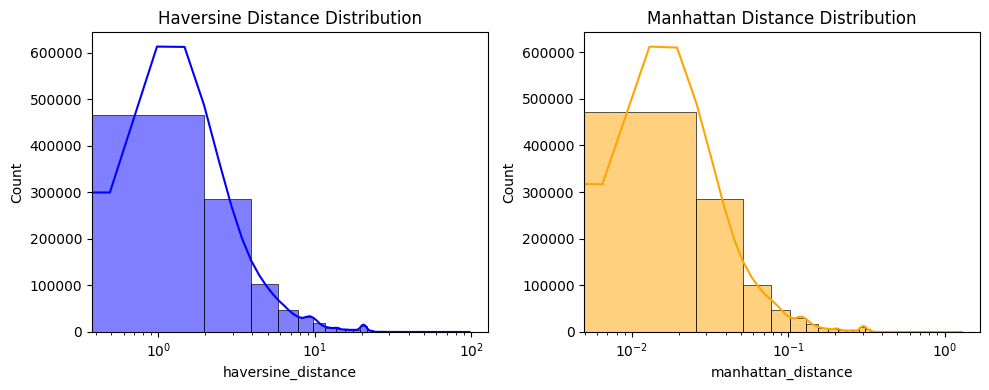

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(train['haversine_distance'], bins=50, kde=True, color='blue')
plt.xscale('log')
plt.title('Haversine Distance Distribution')

plt.subplot(1,2,2)
sns.histplot(train['manhattan_distance'], bins=50, kde=True, color='orange')
plt.xscale('log')
plt.title('Manhattan Distance Distribution')

plt.tight_layout()
plt.show()

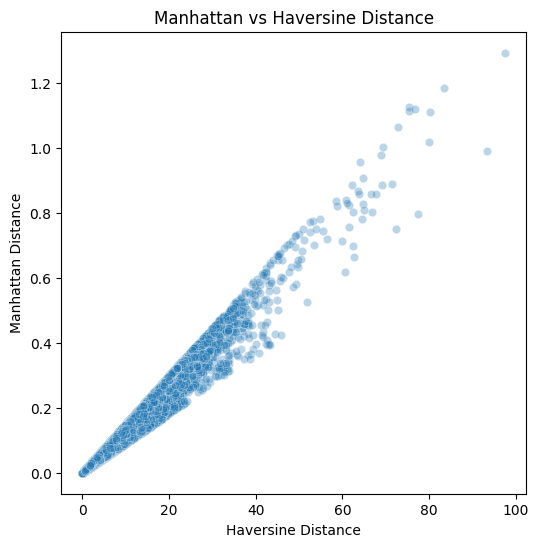

In [47]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='haversine_distance', y='manhattan_distance', data=train, alpha=0.3)
plt.title('Manhattan vs Haversine Distance')
plt.xlabel('Haversine Distance')
plt.ylabel('Manhattan Distance')
plt.show()

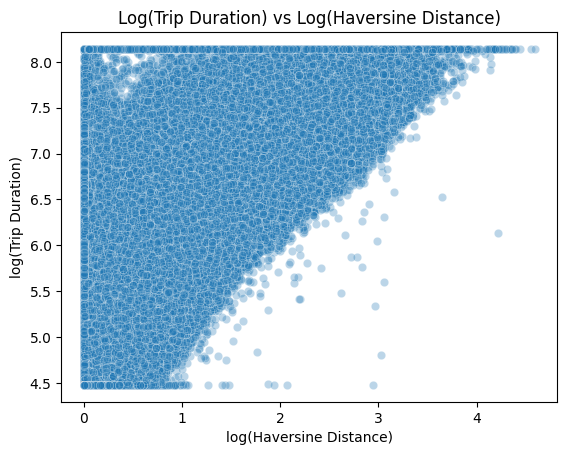

In [49]:
sns.scatterplot(
    x=np.log1p(train['haversine_distance']),
    y= train['log_trip_duration'],
    alpha=0.3
)
plt.title('Log(Trip Duration) vs Log(Haversine Distance)')
plt.xlabel('log(Haversine Distance)')
plt.ylabel('log(Trip Duration)')
plt.show()

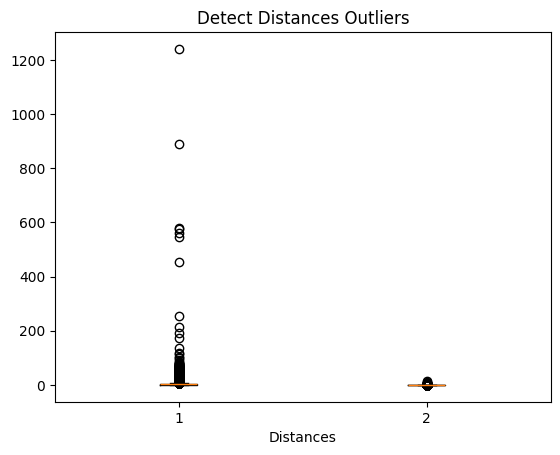

In [39]:
plt.boxplot([train['haversine_distance'],train['manhattan_distance']])
plt.xlabel('Distances')
plt.title('Detect Distances Outliers')
plt.show()

In [50]:
train = train[train['haversine_distance'] < 100]

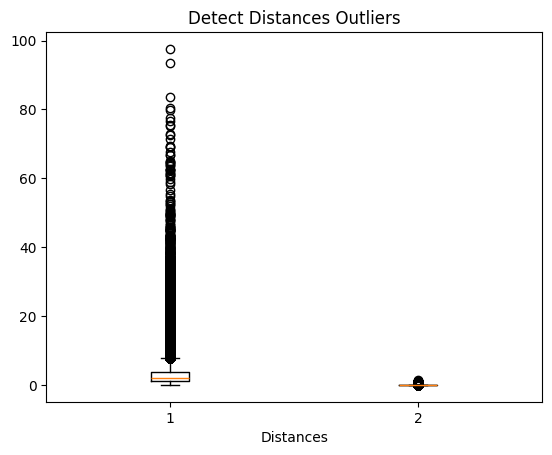

In [51]:
plt.boxplot([train['haversine_distance'],train['manhattan_distance']])
plt.xlabel('Distances')
plt.title('Detect Distances Outliers')
plt.show()

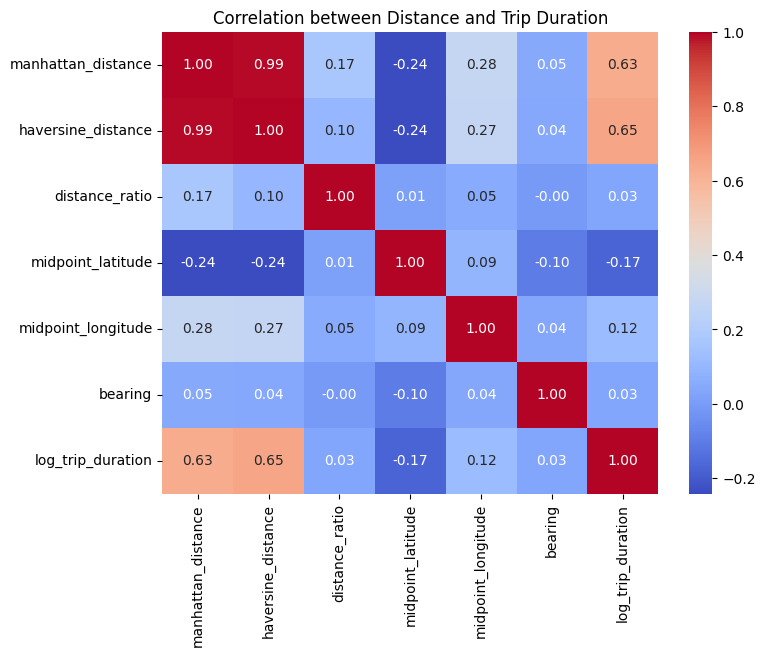

In [42]:
corr = train[['manhattan_distance','haversine_distance','distance_ratio','midpoint_latitude','midpoint_longitude','bearing','log_trip_duration']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Distance and Trip Duration")

plt.show()

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999945 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendor_id              999945 non-null  int64         
 1   pickup_datetime        999945 non-null  datetime64[ns]
 2   passenger_count        999945 non-null  int64         
 3   pickup_longitude       999945 non-null  float64       
 4   pickup_latitude        999945 non-null  float64       
 5   dropoff_longitude      999945 non-null  float64       
 6   dropoff_latitude       999945 non-null  float64       
 7   store_and_fwd_flag     999945 non-null  object        
 8   trip_duration          999945 non-null  int64         
 9   trip_duration_clipped  999945 non-null  float64       
 10  log_trip_duration      999945 non-null  float64       
 11  day                    999945 non-null  int32         
 12  month                  999945 non-null  int32    